In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import random
import seaborn as sns
from scipy import stats as st

from catboost import (
    Pool, 
    CatBoostClassifier,
    cv
)
from category_encoders.binary import BinaryEncoder

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (
    MinMaxScaler,
    FunctionTransformer
)

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    LabelEncoder,
    PolynomialFeatures
)

from sklearn.metrics import ( 
    f1_score
)

import warnings
from imblearn.combine import SMOTETomek

from phik import phik_matrix
from phik.report import plot_correlation_matrix

# вывод всех столбцов и строк, независимо от их количества.
pd.set_option('display.max_columns', None)

# отключаем предупреждение
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
startups_train = pd.read_csv(
        r'...\kaggle_startups_train_28062024.csv',
        decimal=',')
startups_test = pd.read_csv(
        r'...\kaggle_startups_test_28062024.csv',
        decimal=',')
startups = pd.read_csv(
        r'...\kaggle_startups_sample_submit_28062024.csv',
        decimal=',')

In [23]:
display(startups_train.head())

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,category,lifetime_year,funding_year
0,Lunchgate,Online Reservations Restaurants,828626.0,1,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN,2998,Online,8,103579.0
1,EarLens,Manufacturing Medical Medical Devices,2000000.0,1,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN,4748,Manufacturing,13,153847.0
2,Reviva Pharmaceuticals,Biotechnology,2000000.0,1,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN,4383,Biotechnology,12,166667.0
3,Sancilio and Company,Health Care,22250000.0,1,other,other,other,other,3,2004-01-01,2011-09-01,2014-07-18,NaN,5114,Health,14,1589286.0
4,WireTough Cylinders,Manufacturing,3551404.0,1,USA,VA,other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN,2791,Manufacturing,7,507344.0


In [24]:
display(startups_test.head())

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,category,lifetime_year,funding_year,status
0,Crystalsol,Clean Technology,2819200.0,NIC,17,other,other,1,2009-07-01,2009-07-01,3501,Clean,9,313245.0,operating
1,JBI Fish & Wings,Hospitality,3644165.0,USA,TN,other,Humboldt,1,2010-07-28,2010-07-28,2717,Hospitality,7,520595.0,operating
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,Finance,3,142753.0,operating
3,Imagine Communications,Software Video Video Streaming,2000000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,Software,13,153847.0,operating
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,Software,17,266471.0,operating


In [3]:
# к формату float
startups_train['funding_total_usd'] = (
    startups_train['funding_total_usd']
    .astype(float)
)

# к формату float
startups_test['funding_total_usd'] = (
    startups_test['funding_total_usd']
    .astype(float)
)

# форматируем столбец
startups_train['founded_at'] = pd.to_datetime(startups_train['founded_at'])

# количество дней
startups_train['lifetime'] = (pd.to_datetime('2018-01-01') - startups_train['founded_at']).dt.days

# одирование целевого признака
startups_train.status = startups_train.status.apply(lambda x: 1 if x == 'operating' else 0)

In [4]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.5):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        # к формату float
        X['funding_total_usd'] = X['funding_total_usd'].astype(float)
        
        # сохраняем медиану для замены пропусков
        self.median_funding = X['funding_total_usd'].median() 
        return self
    
    def transform(self, X):
        # обработка бесконечных значений
        X.replace([np.inf, -np.inf], np.nan, inplace=True)

        # преобразование строк с плавающей точкой в NaN в категориальных столбцах
        for col in X.select_dtypes(include=['category', 'object']).columns:
            X[col] = X[col].apply(lambda x: np.nan if isinstance(x, float) else x)
    
        # преобразование строковых значений в NaN в числовых столбцах
        for col in X.select_dtypes(include=['float64', 'int64']).columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')
            
        # обработка пропусков в категориальных признаках
        categorical_cols = ['category_list', 'country_code', 
                            'state_code', 'region', 'city']
        X[categorical_cols] = X[categorical_cols].fillna('other')

        # замена строк с '- Other' на 'other' в region
        X['region'] = (
            X['region']
            .replace(to_replace=r'.* - Other', value='other', regex=True) 
        )
        
        # замена строк с '|' на ' ' в category_list
        X['category_list'] = (
            X['category_list']
            .apply(lambda x: x.replace('|', ' ') if isinstance(x, str) else x)
        )

        # создание столбца по первому символу
        X['category'] = (
            X['category_list']
            .apply(lambda x: x.split()[0] if isinstance(x, str) and x else '')
        )

        # признак lifetime_year
        X['lifetime_year'] = (X['lifetime'] / 365).astype(int)

        # фильтрация выбросов в funding_total_usd
        lower_bound = (
            X['funding_total_usd']
            .quantile(0.25) - self.threshold * (
                X['funding_total_usd']
                .quantile(0.75) - X['funding_total_usd'].quantile(0.25)
            )
        )
        upper_bound = (
            X['funding_total_usd']
            .quantile(0.75) + self.threshold * (
                X['funding_total_usd']
                .quantile(0.75) - X['funding_total_usd'].quantile(0.25)
            )
        )
        
        # замена выбросов на медиану
        X['funding_total_usd'] = np.where(
            (X['funding_total_usd'] < lower_bound) | (X['funding_total_usd'] > upper_bound),
            self.median_funding,
            X['funding_total_usd']
        )
        
        # обработка пропусков в funding_total_usd
        X['funding_total_usd'] = (
            X['funding_total_usd']
            .fillna(X['funding_total_usd'].mean())
            .apply(np.ceil)
        )

        # признак funding_year
        X['funding_year'] = (
            X['funding_total_usd'] / X['lifetime_year']
        ).apply(np.ceil)

        return X

In [5]:
# создадим Pipeline предобработки
pre_pipe = Pipeline(
    [
        ('custom_transformer', CustomTransformer(threshold=1.5))
    ]
)

In [6]:
# применяем пайплайн к данным
startups_train_pre, startups_test_pre = (
    [pre_pipe.fit_transform(data) for data in [startups_train, startups_test]]
)

In [7]:
# создаём список с наименованиями непрерывных признаков
interval_cols = startups_train_pre.select_dtypes(include='number').columns.to_list()

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(
    startups_train_pre.drop(
        [
            'name', 
            'category_list', 
            'city', 
            'founded_at',
            'first_funding_at', 
            'last_funding_at', 
            'closed_at', 
            'lifetime_year'
            ], 
        axis=1
    ),
    interval_cols=interval_cols
)

Размер матрицы (9, 9)


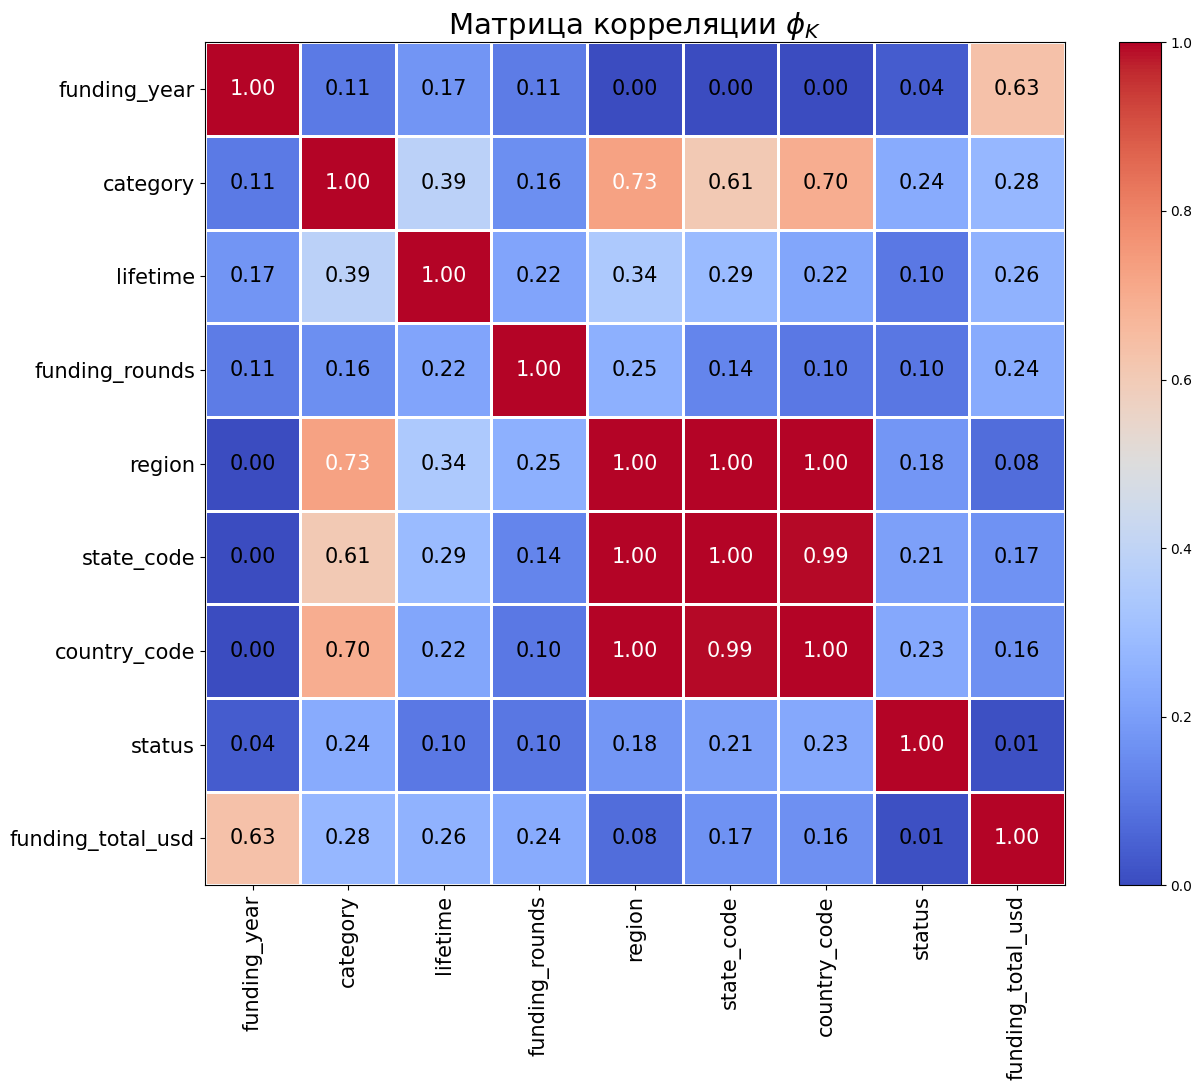

In [8]:
# строим сматрицу корреляции
print(f'Размер матрицы {phik_overview.shape}')
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, 
    vmax=1, 
    color_map='coolwarm',
    title=f'Матрица корреляции $\phi_K$',
    fontsize_factor=1.5,
    figsize=(13, 11)
)
plt.show()

In [9]:
RANDOM_STATE = 42
TEST_SIZE = 0.2499238327366897

# создаем тренировочную и валидационную выборки
X_train, X_valid, y_train, y_valid = (
    train_test_split(
        startups_train
        .drop(
            [
                'name', 
                'status', 
                'founded_at',
                'first_funding_at', 
                'last_funding_at', 
                'closed_at', 
            ],
            axis=1
            ),
        startups_train.status,
        test_size = TEST_SIZE,
        random_state = RANDOM_STATE,
        stratify = startups_train.status
        )
)

In [10]:
cat_columns = X_train.select_dtypes(include='object').columns.to_list()
data = Pool(data=X_train, label=y_train, cat_features=cat_columns)

In [11]:
model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=10,
    subsample=0.9,
    colsample_bylevel=0.8,
    early_stopping_rounds=50,
    eval_metric='F1', 
    random_seed=RANDOM_STATE,
    class_weights = {0: 9, 1: 1}
)

In [12]:
model.fit(data, verbose=False)

In [13]:
predict = model.predict(X_valid)

In [14]:
f1_score(y_valid, predict, average='binary')

0.8680665789831739

In [15]:
importances = pd.DataFrame(
    {
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }
).sort_values('Importance', ascending=False)
importances

,Feature,Importance
7,lifetime,16.991389
8,category,14.525687
1,funding_total_usd,11.007193
10,funding_year,10.628774
3,state_code,8.645290
2,country_code,7.761834
0,category_list,6.900723
4,region,6.630501
5,city,6.483867
6,funding_rounds,5.990898


In [16]:
X_test = (
    startups_test_pre.drop(
            [
                'name', 
                'first_funding_at', 
                'last_funding_at', 
            ],
            axis=1
            )
)

In [17]:
f1_score(y_valid, model.predict(X_test), average='binary')

0.8426971346318204

In [18]:
results = startups_test_pre
results['status'] = model.predict(X_test)

In [19]:
results['status'].value_counts()

status
1    10335
0     2790
Name: count, dtype: int64

In [20]:
results['status'] = results['status'].apply(lambda x: 'operating' if x == 1 else 'closed')

In [21]:
results = results[['name', 'status']]

In [22]:
results.to_csv('output1.csv', index=False) 

Привет, подскажи пожалуйста, где моя ошибка? На Kaggle максисум 0.22 пучилось выжать.